In [13]:
import pandas as pd
import numpy as np
import time

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler

from matplotlib import pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh import palettes
from bokeh.models import Legend

%matplotlib inline
output_notebook()

Loading BokehJS ...

## PCA

In [4]:
t0 = time.time()
df = pd.read_hdf("./data/mRNA_lognorm_RobustScaled.hdf", 
                 index_col="sample_id")
print("loading matrix takes {0} seconds".format(time.time()-t0))

loading matrix takes 0.7393283843994141 seconds


In [5]:
pca = PCA()
t0 = time.time()
pca.fit(df)
print("fitting PCA to this matrix takes {0} seconds".format(time.time()-t0))

fitting PCA to this matrix takes 710.9927313327789 seconds


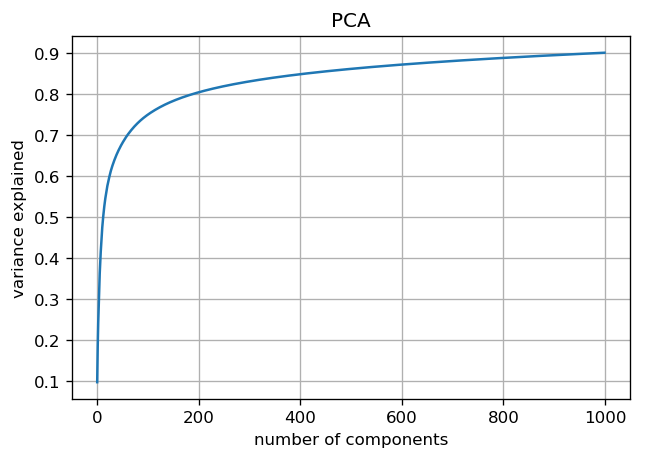

In [8]:
fig = plt.figure(dpi=120)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:1000])
plt.ylabel("variance explained")
plt.title("PCA")
plt.grid()
plt.xlabel("number of components")

In [10]:
# get number of components where 60%, 70%, 80% and 90% of of variations are preserved
def get_n_component_for_x_variance(x, variance_list):
    for i, variance in enumerate(variance_list):
        if variance > x:
            return i 
variance_preserved = np.cumsum(pca.explained_variance_ratio_)

variance_dict = {}
for variance in [0.2, 0.6,0.7,0.8,0.9]:
    variance_dict[variance] = get_n_component_for_x_variance(variance, variance_preserved)
print(variance_dict)

{0.2: 2, 0.6: 25, 0.7: 60, 0.8: 190, 0.9: 997}


In [11]:
X_tranformed = pca.transform(df)

In [12]:
for variance, n in variance_dict.items():
    df_PCA = pd.DataFrame(X_tranformed[:, :n], index=df.index)
    df_PCA.to_csv("./data/mRNA_PCA_{0}_variance.csv".format(variance))

### Histogram of PCA processed data

variance=0.2, n_components=2


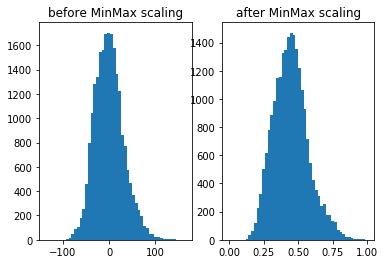

variance=0.6, n_components=25


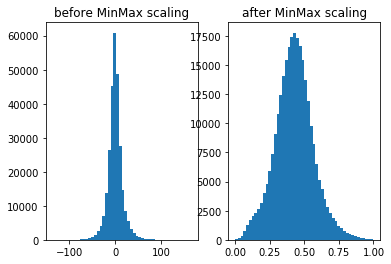

variance=0.7, n_components=60


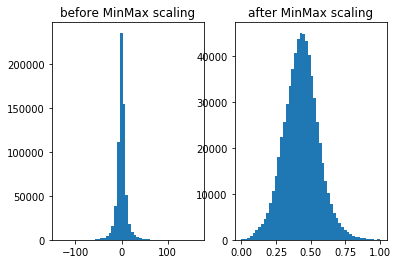

variance=0.8, n_components=190


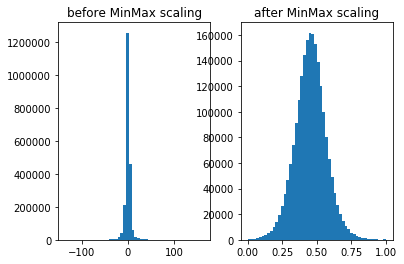

variance=0.9, n_components=997


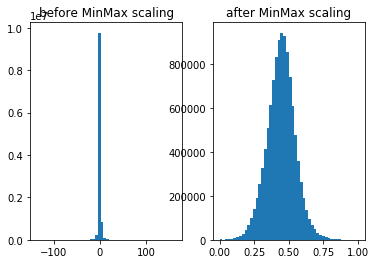

In [17]:
for variance, n in variance_dict.items():
    print("variance={0}, n_components={1}".format(variance, n))
    df= pd.read_csv("./data/mRNA_PCA_{0}_variance.csv".format(variance), 
                    index_col="sample_id")
    scaler = MinMaxScaler()
    X_transform = scaler.fit_transform(df)
    f, axes = plt.subplots(1, 2)
    axes[0].hist(df.as_matrix().flatten(), bins=50)
    axes[0].set_title("before MinMax scaling")
    axes[1].hist(X_transform.flatten(), bins=50)
    axes[1].set_title("after MinMax scaling")
    plt.show()
    
    # saved transformed PCA results
    df_scaled = pd.DataFrame(X_transform, index=df.index, columns=df.columns)
    df_scaled.to_csv("./data/mRNA_PCA_{0}_variance_MinMaxScaled.csv".format(variance))

### Plot first two components of PCA

In [31]:
df2 = pd.read_csv("./data/mRNA_PCA_0.2_variance_RobustScaled.csv", index_col="sample_id")
label_df = pd.read_csv("./data/labels.csv", index_col="sample_id")
joined_df = label_df.join(df2).dropna()

In [32]:
joined_df.sample(5)

,label_tissue,label_gender,label_tumor,0,1
sample_id,,,,,
TCGA-DU-A7TG-01A-21R-A34R-07,LGG,MALE,primary solid tumor,-1.564712,1.750636
TCGA-CZ-4854-01A-01R-1305-07,KIRC,MALE,primary solid tumor,-0.690242,0.092500
TCGA-18-5592-01A-01R-1635-07,LUSC,MALE,primary solid tumor,0.140214,-0.836004
TCGA-K4-A4AC-01A-21R-A26T-07,BLCA,MALE,primary solid tumor,1.266252,-0.393087
TCGA-29-A5NZ-01A-11R-A406-31,OV,FEMALE,primary solid tumor,-0.976714,-0.559854


In [33]:
p = figure(plot_width=800, plot_height=700)
colors = palettes.Category10[10]
for i, datatype in enumerate(set(joined_df["label_gender"])):
    subset_df = joined_df[joined_df["label_gender"] == datatype]
    p.circle(subset_df["0"], subset_df["1"], size=3, color=colors[i], alpha=0.6, legend=datatype)
p.legend.click_policy="hide"
show(p)

In [34]:
colored_tissues = joined_df["label_tissue"].value_counts().index[:20]
rest_of_tissues = joined_df["label_tissue"].value_counts().index[20:]

p = figure(plot_width=800, plot_height=700)
colors = palettes.Category20[20]
for i, datatype in enumerate(colored_tissues):
    subset_df = joined_df[joined_df["label_tissue"] == datatype]
    p.circle(subset_df["0"], subset_df["1"], size=3, color=colors[i], legend=datatype)
    
for i, datatype in enumerate(rest_of_tissues):
    subset_df = joined_df[joined_df["label_tissue"] == datatype]
    p.circle(subset_df["0"], subset_df["1"], size=3, color="grey", legend="Others")
    
p.legend.click_policy="hide"
p.legend.location = "bottom_left"
show(p)

In [35]:
p = figure(plot_width=800, plot_height=700)
colors = palettes.Category10[10]
for i, datatype in enumerate(set(joined_df["label_tumor"])):
    subset_df = joined_df[joined_df["label_tumor"] == datatype]
    p.circle(subset_df["0"], subset_df["1"], size=3, alpha=0.8,
             color=colors[i], legend=datatype)
p.legend.click_policy="hide"
show(p)